## 第九章 非监督模式识别

这一章介绍的是非监督学习中的聚类。主要分为两个思路：一个是根据概率模型进行聚类，另一个是根据数据设计算法进行聚类。

书中在介绍概率模型聚类用到了大篇幅的概率公式推导，可以说完全看不懂，我尝试了一个小时之后彻底放弃，只能赌一手考研不考。至于到底考不考，等我今年考完研就知道了。

下面是书上介绍的基于数据的算法。

### 一、C均值算法

C均值算法的思想是最小化误差平方和，即最小化$J_e = \sum_{i=1}^c\sum_{\mathbf{y}\in\Gamma_i}||\mathbf{y}-\mathbf{m}_i||^2$。

具体算法如下：

1. 初始化划分$c$个聚类，具体初始化划分书上给了好多方法，不过都是启发式的算法，具体怎么初始化划分都可以。
2. 遍历所有样本，如果当前样本所在的类的样本数量$N_i > 1$，则比较把这个样本移动到别的类造成的误差平方和变化，即比较：

$$\begin{align}
\rho_j &= \frac{N_j}{N_j + 1}||\mathbf{y}-\mathbf{m}_j||^2, \quad j\neq i \\
\rho_i &= \frac{N_i}{N_i - 1}||\mathbf{y}-\mathbf{m}_i||^2
\end{align}$$

其中$\mathbf{m}_i$是第$i$类的均值。

3. 考察$\rho_j$中的最小值$\rho_k$，如果$\rho_k<\rho_i$，则把当前样本从$\Gamma_i$类移动到$\Gamma_k$类中。移动后重新计算$\mathbf{m}_i$是第$i$。
4. 如果当前一轮遍历把所有样本都考察过了，并且没有移动任何样本，说明已经达到了局部的最小误差平方和，认为收敛。

下面实现的代码中，我采用了寻找代表点的方法(2)和初始化分类的方法(1)。其实这些方法实际效果区别不大，用简单的就可以了。

实现如下：

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [59]:
class CMeans:
    """
    实现C均值算法的类
    """
    def __init__(self, c: int):
        """
        构造函数
        :param c: 指定的聚类数量
        """
        self._c: int = c
        # self._c表示聚类数

        self._d: int = 0
        # self._d表示样本维数

        self._N: int = 0
        # self._N表示样本总数

        self._X: np.ndarray = np.zeros(0)
        # self._X存储所有样本

        self._clusters: list[set[int]] = []
        # self._clusters[i] = {1, 3} 表示第i个聚类中包含1号样本和2号样本

        self._m: list[np.ndarray] = [np.zeros(0)] * c
        # self._m[i]表示第i个聚类的均值

        self.costs: list[float] = []
        # self.costs记录每次迭代后的误差平方和

    def _update_mean(self):
        """
        更新每一类的均值
        """
        for i in range(self._c):
            cluster_sum = np.zeros(self._d)
            for j in self._clusters[i]:
                cluster_sum += self._X[j]
            self._m[i] = cluster_sum / len(self._clusters[i])

    def initialize(self, _X: np.ndarray):
        """
        初始化聚类
        :param _X: 样本矩阵，每一行是一个样本（N * d）
        """
        if _X.shape[0] <= self._c:
            raise Exception("样本数量必须比分类数量大！")

        self._X = _X
        self._N = _X.shape[0]
        self._d = _X.shape[1]

        np.random.shuffle(_X)
        for i in range(self._c):
            self._clusters.append({i})
        self._update_mean()

        for i in range(self._c, _X.shape[0]):
            min_distance = 999999
            min_index = 0
            for j in range(self._c):
                distance = np.sum((_X[i] - self._m[j]) ** 2)
                if min_distance > distance:
                    min_distance = distance
                    min_index = j
            self._clusters[min_index].add(i)
            self._update_mean()

    def _compute_cost(self) -> float:
        """
        计算误差平方和
        :return: 误差平方和
        """
        ret = 0
        for i in range(self._c):
            for j in self._clusters[i]:
                ret += np.sum((self._X[j] - self._m[i]) ** 2)
        return ret

    def cluster(self):
        """
        开始运行迭代聚类算法
        """
        clusters_order = np.random.permutation(self._c)
        # 随机生成遍历的顺序

        iters = 0
        confirmed_samples = 0
        while confirmed_samples < self._N:
            flag = False
            for c in clusters_order:
                if flag:
                    break
                cluster = list(self._clusters[c])
                N_i = len(self._clusters[c])
                samples_order = np.random.permutation(N_i)
                # 随机生成遍历的顺序
                for i in samples_order:
                    if flag:
                        break
                    rho_i = np.sum(N_i / (N_i - 1) * (self._X[cluster[i]] - self._m[c]) ** 2)
                    min_value_of_rho_j = 999999
                    min_cluster_of_rho_j = 0
                    for j in range(self._c):
                        if c == j:
                            continue
                        N_j = len(self._clusters[j])
                        rho_j = np.sum(N_j / (N_j + 1) * (self._X[cluster[i]] - self._m[j]) ** 2)
                        if min_value_of_rho_j > rho_j:
                            min_value_of_rho_j = rho_j
                            min_cluster_of_rho_j = j
                    iters += 1
                    if min_value_of_rho_j < rho_i:
                        self._clusters[c].remove(cluster[i])
                        self._clusters[min_cluster_of_rho_j].add(cluster[i])
                        self._update_mean()
                        self.costs.append(self._compute_cost())
                        confirmed_samples = 0
                        flag = True
                        break
                    confirmed_samples += 1
                    if iters >= 1000000:
                        raise Exception("迭代了100000次还不收敛，数据可能有问题")

    def result(self) -> np.ndarray:
        """
        获取聚类结果
        :return: 聚类结果向量
        """
        ret = np.zeros(self._N, dtype=int)
        for i, cluster in enumerate(self._clusters):
            for j in cluster:
                ret[j] = i
        return ret

接下来用水仙花的数据来测试一下聚类效果

In [60]:
iris = load_iris()
X = iris.data
y = iris.target

cmeans = CMeans(3)
cmeans.initialize(X)
cmeans.cluster()
y_clustered = cmeans.result()
print("原始数据类别为：")
print(y)
print("聚类获得的类别为：")
print(y_clustered)

原始数据类别为：
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
聚类获得的类别为：
[1 1 1 0 1 1 1 0 2 0 2 1 0 1 2 0 1 1 0 1 2 0 2 0 0 1 1 2 2 0 0 1 2 1 2 2 2
 0 1 0 0 1 2 2 1 2 0 2 2 0 1 2 2 1 0 1 1 2 0 2 0 2 2 1 0 2 1 2 2 0 1 1 1 1
 2 1 1 0 2 2 2 2 2 1 0 1 1 0 2 1 0 2 1 1 1 1 1 0 2 0 0 1 1 2 1 0 1 2 1 0 2
 2 1 1 2 1 2 1 0 0 2 1 1 1 1 1 0 0 1 1 1 1 2 0 1 2 2 2 1 2 2 2 0 2 2 0 1 1
 1 0]


可以看到聚类获得类别和原始类别非常不同，这是非常正常的现象。

接下来可视化的观察一下随着迭代，误差平方和的变化。

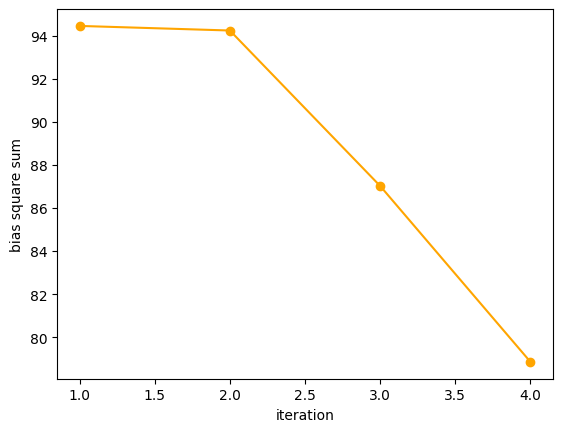

In [71]:
costs = cmeans.costs
iters = np.arange(1, len(costs) + 1)
plt.plot(iters, costs, color='orange', marker='o')
plt.xlabel("iteration")
plt.ylabel("bias square sum")
plt.show()

从图像可以看出只迭代了三次，每次迭代误差平方和都在下降。

### 二、ISODATA方法